In [1]:
# v2.4_UCB
# Bayesian Optimization
# xgboost as gold with early stop
# different regressor:
# xgboost , sklearn MLP, keras ANN, linear regression, random forest

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load All Dataset in One DataFrame
dataset = pd.concat([pd.read_csv('no_controls/plate_AL_{}_raw_yield_and_std.csv'.format(i)) for i in range(1,11)], ignore_index=True)
X = dataset.iloc[:, 0:11].values
y = dataset.iloc[:, 11].values

In [3]:
# define our visualiser
def boxplot(data, group_name, quantity, title = '', point_size = 10):
    plt.style.use('seaborn-whitegrid')
    plt.style.use('seaborn-poster')
    fig, ax = plt.subplots(1, 1)
    ax.grid(zorder=0)
    # Usual boxplot
    ax = sns.boxplot(x=group_name, y=quantity, data=data)
    # Add jitter with the swarmplot function.
    ax = sns.swarmplot(x=group_name, y=quantity, data=data, color='k', size=point_size)
    ax.set_title(title)
    return ax

In [4]:
# Define our GOLD STANDARD MODEL
gold_regressor = xgb.XGBRegressor(
objective = 'reg:squarederror',
n_estimators = 500,
learning_rate = 0.01,
max_depth = 6,
min_child_weight = 1,
subsample = 0.8
)
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# Training ...
gold_regressor.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric='mae', early_stopping_rounds=15, verbose=0)

# Predicting the Test set results
y_pred = gold_regressor.predict(X_test)

# Prediction Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print('mse :',mse)
print('mae :',mae)
print('R2 :', r2)

mse : 0.02011351886147322
mae : 0.09972715930938722
R2 : 0.9604070792316474


In [5]:
## reconstruct the Paper plot
# Part 1: Reshape Dataset
# Load All Dataset in One DataFrame
box_data = []
for i in range(10):
    temp = pd.read_csv('no_controls/plate_AL_{}_raw_yield_and_std.csv'.format(i+1))
    temp['Step'] = 'Step_{}'.format(i+1)
    box_data.append(temp)
box_dataset = pd.concat(box_data, ignore_index=True)

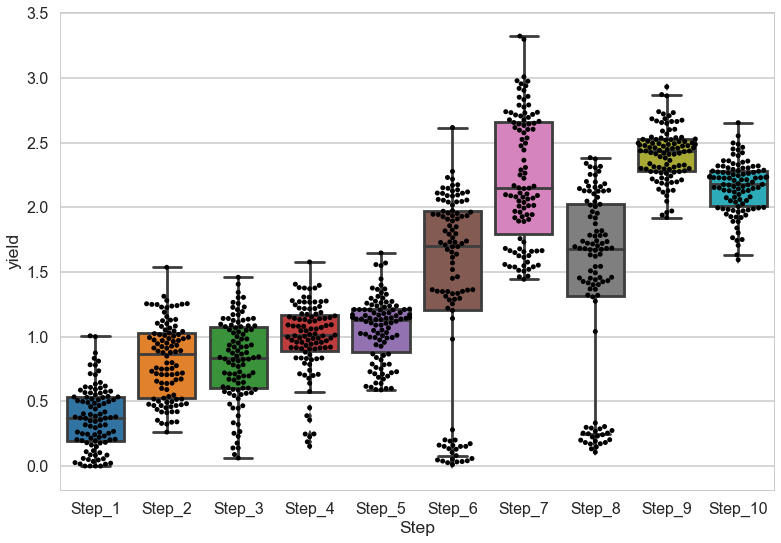

In [6]:
# Part 2: Plotting
boxplot(box_dataset, 'Step', 'yield', point_size=5)

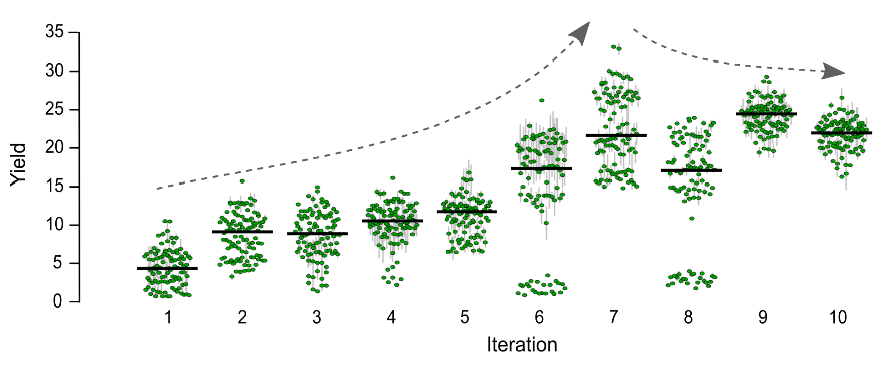

In [9]:
# Part3: Compare to Real One
from IPython.display import Image
Image("Paper_Plot.png")

## Active Learning

In [7]:
# Part 1: choose grid for our metabolite conc

# Allowed concentrations
allowed_conc ={
'nad': (0.033, 0.33),
'folinic_acid': (0.0068, 0.068),
'coa_conc': (0.026, 0.26),
'nucleo_mix': (0.15, 1.5),
'spermidine': (0.1, 1.0),
'pga': (3.0, 30.0),
'aa': (0.15, 1.5),
'trna': (0.02, 0.2),
'mg_gluta': (0.4, 4.0),
'camp': (0.075, 0.75),
'K_gluta': (8.0, 80.0)}

In [8]:
# Part 2: make a random input for our model
def random_input(allowed_conc, n=100, rounded=3, verbose=0):
    X_train = []
    for data_point in range(n):
        input_data = []
        if (data_point % 10000 == 0) and verbose:
            print(data_point)
        for key, value in allowed_conc.items():
            input_data.append(np.round(np.random.uniform(*value), rounded))
        X_train.append(input_data)

    X_train = np.array(X_train)
    return X_train

In [3]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# keras ann
# Artificial Neural Network

# Initialising the ANN
regressor_ann = Sequential()

# Adding the input layer and the first hidden layer
regressor_ann.add(Dense(units = 100, kernel_initializer = 'normal', activation = 'relu', input_dim = 11))

# Adding the second hidden layer
regressor_ann.add(Dense(units = 100, kernel_initializer = 'normal', activation = 'relu'))

# Adding the second hidden layer
regressor_ann.add(Dense(units = 20, kernel_initializer = 'normal', activation = 'relu'))

# Adding the output layer
regressor_ann.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'relu'))

# Compiling the ANN
regressor_ann.compile(optimizer = 'nadam', loss = 'mean_absolute_error', metrics = ['mae'])

Using TensorFlow backend.


In [11]:
gold_regressor.predict(random_input(allowed_conc))

array([0.2497235 , 0.9072745 , 0.7357099 , 0.7961165 , 0.43802118,
       0.32689556, 0.9483439 , 0.7154198 , 0.7503103 , 0.29861566,
       0.07915202, 0.2949915 , 0.27561814, 0.54836035, 1.6727912 ,
       0.5158986 , 0.75237393, 0.6925451 , 0.19530213, 1.2553663 ,
       1.3544965 , 0.15703747, 0.4638064 , 1.0083442 , 0.24844679,
       0.7669983 , 0.37141836, 0.7680769 , 0.23275688, 1.658678  ,
       0.26745677, 0.92425895, 0.2835795 , 0.43509996, 0.26829058,
       0.18104991, 1.1505451 , 0.33112794, 0.27040836, 0.2822504 ,
       0.33246845, 0.40411162, 0.4184826 , 0.587372  , 0.3266153 ,
       0.6927464 , 0.8039218 , 0.27247107, 0.19452512, 0.44920698,
       0.43617338, 0.4443245 , 0.67714983, 1.922484  , 0.9195154 ,
       0.31598395, 0.6061702 , 1.9155054 , 0.46074918, 0.21518701,
       0.37764525, 0.2275483 , 0.56625354, 0.578509  , 0.8144739 ,
       0.38717794, 0.16896084, 0.6959044 , 0.4285624 , 0.7282132 ,
       0.28144264, 0.49848557, 0.35659254, 0.20235378, 0.47885

In [18]:
def active_learning(regressor, gold_regressor, allowed_conc, test_size = 100, steps = 10):
    ## first step
    print('step:   1')    
    # make first dataset
    X_train_1 = random_input(allowed_conc, test_size)
    
    # first fit
    regressor.fit(X_train_1, gold_regressor.predict(X_train_1))
    
    # save results
    result = pd.DataFrame(X_train_1)
    result['gold_yield'] = gold_regressor.predict(X_train_1)
    result['step'] = 'step_1'
    
    ## next steps loop
    for step in range(steps-1):
        print('step: ',step+2)
        # make i th dataset
        X_train_1_1 = random_input(allowed_conc, 100000)
        df_1 = pd.DataFrame(X_train_1_1)
        df_1['pred_yield'] = regressor.predict(X_train_1_1)
        df_1 = df_1.sort_values(['pred_yield'], ascending=False)
        X_train_2 = df_1.iloc[0:test_size,0:11].values
        
        # save and add results
        temp_result = pd.DataFrame(X_train_2)
        temp_result['gold_yield'] = gold_regressor.predict(X_train_2)
        temp_result['step'] = 'step_{}'.format(step+2)
        result = pd.concat([result, temp_result], ignore_index=True)
        
        # update and refit regressor
        regressor.fit(result.iloc[:,0:11].values, result.iloc[:,11].values)

    return result, regressor

In [19]:
def bayesian_optimization(regressors_list,
                          gold_regressor,
                          allowed_conc,
                          exploitation=1, exploration=1, test_size=100, steps=10, verbose=0):
    ## first step
    if verbose:
        print('step:  1')    
    # make first dataset
    X_train_1 = random_input(allowed_conc, test_size)
    
    # first fit
    for regressor in regressors_list:
        regressor.fit(X_train_1, gold_regressor.predict(X_train_1))
    
    # save results
    result = pd.DataFrame(X_train_1)
    result['gold_yield'] = gold_regressor.predict(X_train_1)
    result['pred_yield'] = 0.0 # not available but choose 0.0 to avoid further error
    result['step'] = 'step_1'
    
    ## next steps loop
    for step in range(steps-1):
        if verbose>=2:
            print('step: ',step+2)
        # make i th dataset
        X_train_1_1 = random_input(allowed_conc, 100000)
        df_1 = pd.DataFrame(X_train_1_1)
        
        #upper Confidence Bound
        for index, regressor in enumerate(regressors_list):
            df_1['pred_yield_{}'.format(index)] = regressor.predict(X_train_1_1)
        
        df_1['regressors_std'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].std(axis=1)
        df_1['mean_vote'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].mean(axis=1)
        df_1['UCB'] = exploitation * df_1['mean_vote']+ exploration * df_1['regressors_std'] 
        df_1 = df_1.sort_values(['UCB'], ascending=False)
        X_train_2 = df_1.iloc[0:test_size,0:11].values
        
        # save and add results
        temp_result = pd.DataFrame(X_train_2)
        temp_result['gold_yield'] = gold_regressor.predict(X_train_2)
        #temp_result['pred_yield'] = df_1.iloc[0:test_size,11:12].values
        temp_result['pred_yield'] = df_1.mean_vote[0:test_size].values
        temp_result['step'] = 'step_{}'.format(step+2)
        result = pd.concat([result, temp_result], ignore_index=True)
        
        # update and refit regressor
        regressor.fit(result.iloc[:,0:11].values, result.iloc[:,11].values)

    return result, regressor

In [23]:
# define our model that will be trained by Active Learning
regressor_list = [MLPRegressor(hidden_layer_sizes  = (10, 100,100, 20), solver ="adam", max_iter=20000,early_stopping = True, learning_rate = "adaptive"),
                  LinearRegression(),
                  RandomForestRegressor(n_estimators=500),
                  xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 500,learning_rate = 0.01,max_depth = 6,min_child_weight = 1,subsample = 0.8),
                  regressor_ann]

In [22]:
# define our model that will be trained by Bayesian Optimization
regressor_lists_list = [[MLPRegressor(hidden_layer_sizes  = comb, solver ="adam", max_iter=20000,early_stopping = True, learning_rate = "adaptive") for comb in [(10, 100,100, 20),(20, 100,100, 10),(20, 100,100, 20),(10, 100,100, 10),(20, 100,100, 50)]],
                        [LinearRegression() for i in range(5)],
                        [RandomForestRegressor(n_estimators=n) for n in (100, 200, 300, 400, 500)],
                        [xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 500,learning_rate = 0.01,max_depth = 6,min_child_weight = 1,subsample = 0.8) for i in range(5)],
                        [regressor_ann for i in range(5)]]

In [25]:
result_UCB_list = []
for regressors in regressor_lists_list:
    # define our model that will be trained by active learning
    result, _ = bayesian_optimization(regressors, gold_regressor, allowed_conc, test_size=100, steps=10, verbose=2)
    result_UCB_list.append(result)

step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 0.4252 - mae: 0.4252
Epoch 1/1
100/100 [==============================] - 0s 129us/step - loss: 0.2709 - mae: 0.2709
Epoch 1/1
100/100 [==============================] - 0s 140us/step - loss: 0.2843 - mae: 0.2843
Epoch 1/1
100/100 [==============================] - 0s 131us/step - loss: 0.2731 - mae: 0.2731
Epoch 1/1
100/100 [==============================] - 0s 102us/step - loss: 0.2701 - mae: 0.2701
step:  2
Epoch 1/1
200/200 [==============================] - 0s 128us/step - loss: 0.2578 - mae: 0.2578
step:  3
Epoch 1/1
300/300 [================

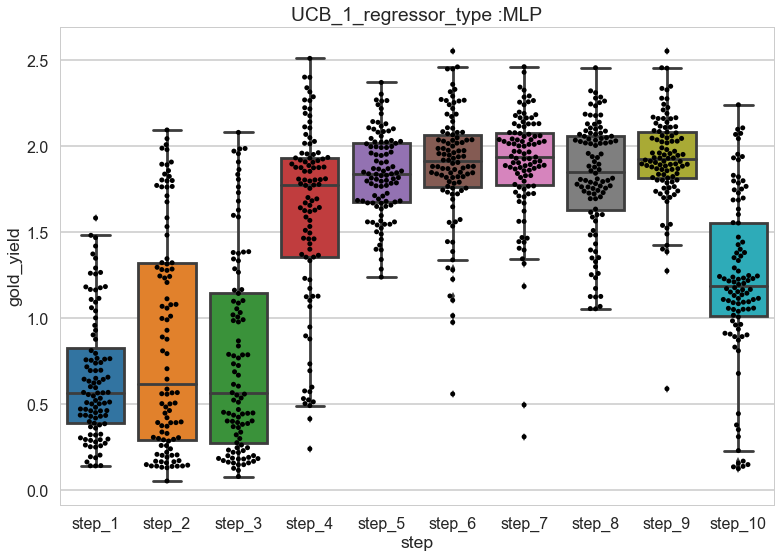

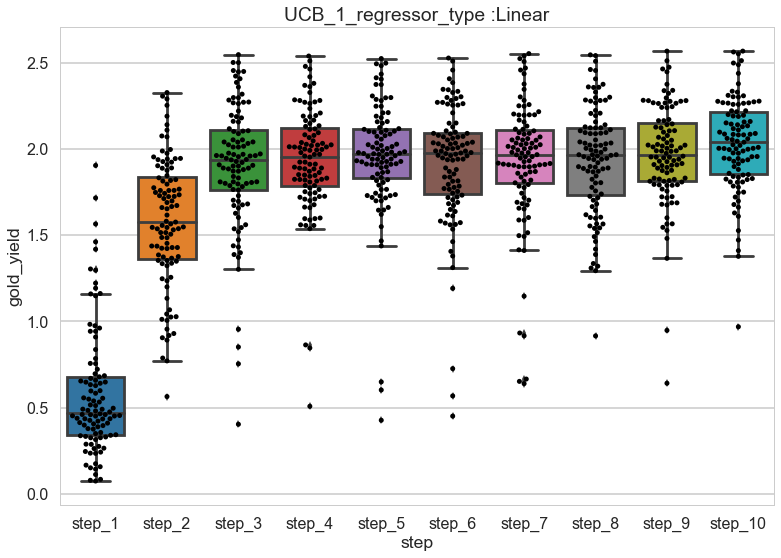

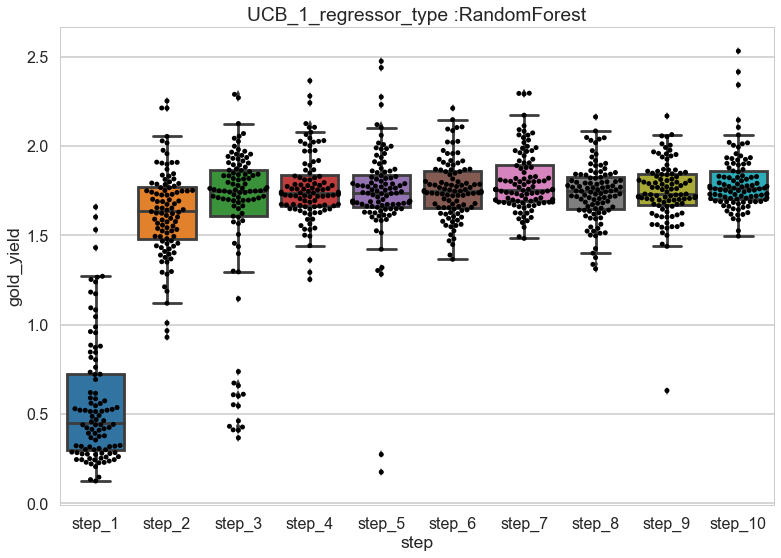

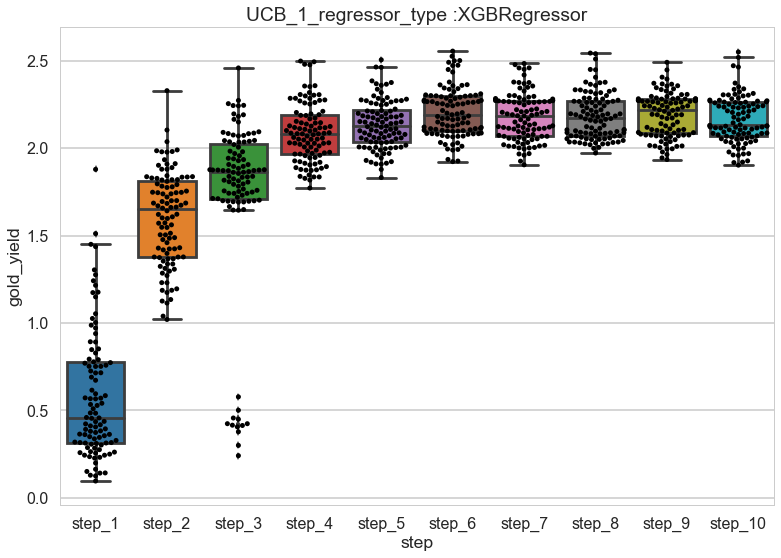

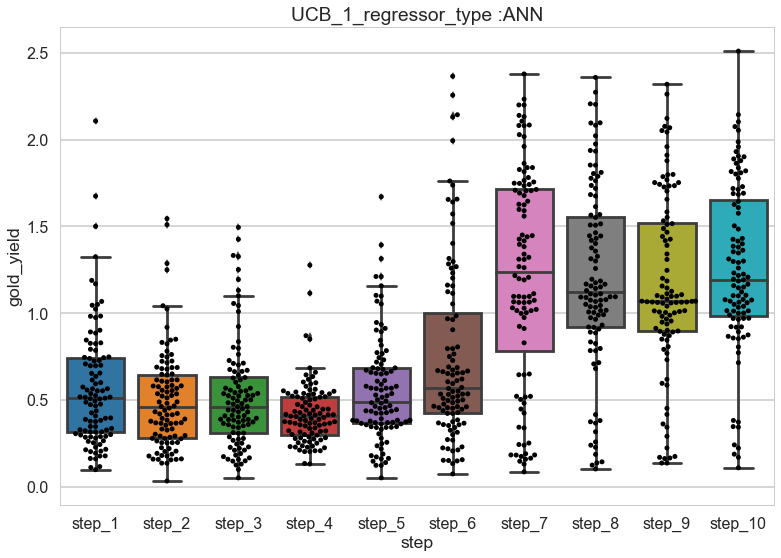

In [29]:
# Plotting
name = ['MLP', 'Linear', 'RandomForest', 'XGBRegressor', 'ANN']
for i in range(len(regressor_lists_list)):
    boxplot(result_UCB_list[i], 'step', 'gold_yield', title='UCB_1_regressor_type :{}'.format(name[i]),point_size=5)

In [27]:
result_UCB_list_2 = []
for regressors in regressor_lists_list:
    # define our model that will be trained by active learning
    result, _ = bayesian_optimization(regressors, gold_regressor, allowed_conc,exploitation=1, exploration=1.41, test_size=100, steps=10, verbose=2)
    result_UCB_list_2.append(result)

step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:  1
Epoch 1/1
100/100 [==============================] - 0s 122us/step - loss: 0.3294 - mae: 0.3294
Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.3147 - mae: 0.3147
Epoch 1/1
100/100 [==============================] - 0s 124us/step - loss: 0.3138 - mae: 0.3138
Epoch 1/1
100/100 [==============================] - 0s 134us/step - loss: 0.3011 - mae: 0.3011
Epoch 1/1
100/100 [==============================] - 0s 111us/step - loss: 0.3149 - mae: 0.3149
step:  2
Epoch 1/1
200/200 [==============================] - 0s 125us/step - loss: 0.3564 - mae: 0.3564
step:  3
Epoch 1/1
300/300 [==============

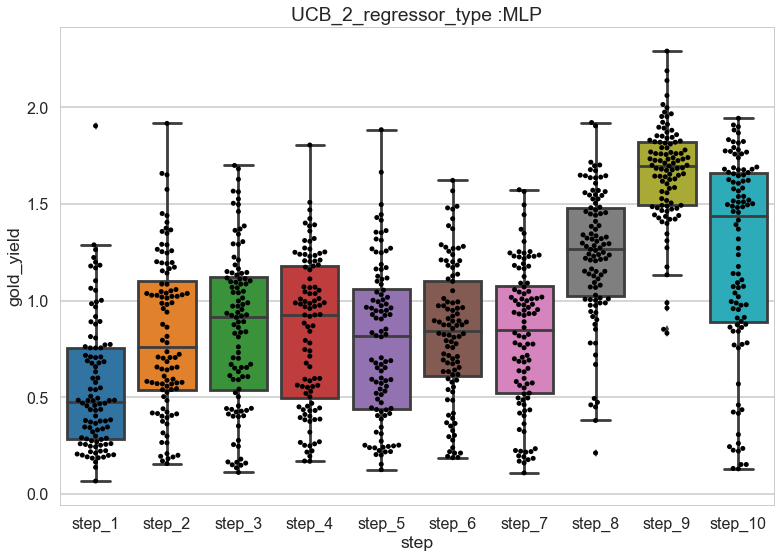

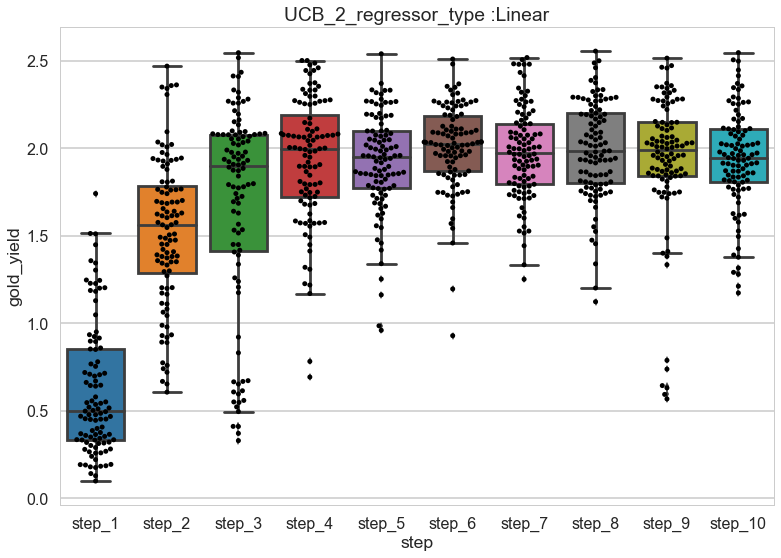

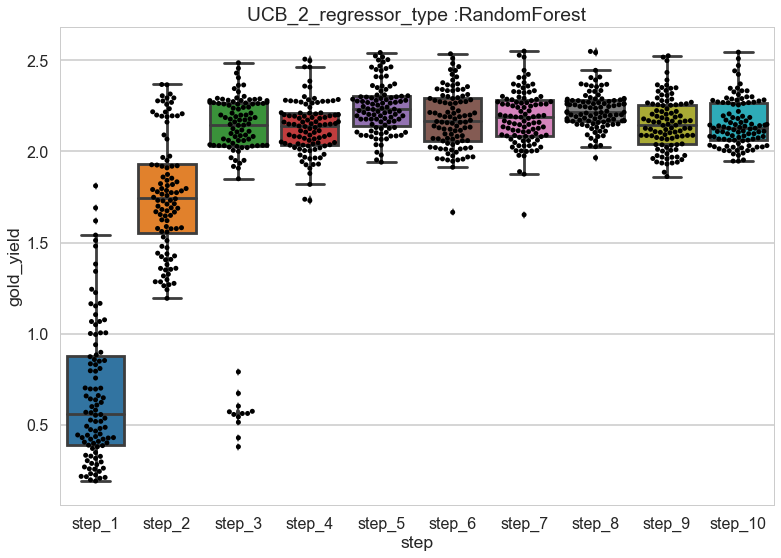

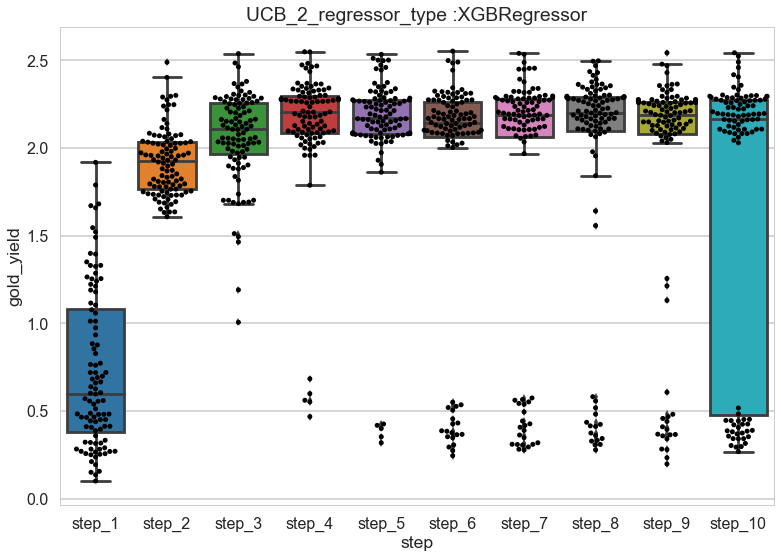

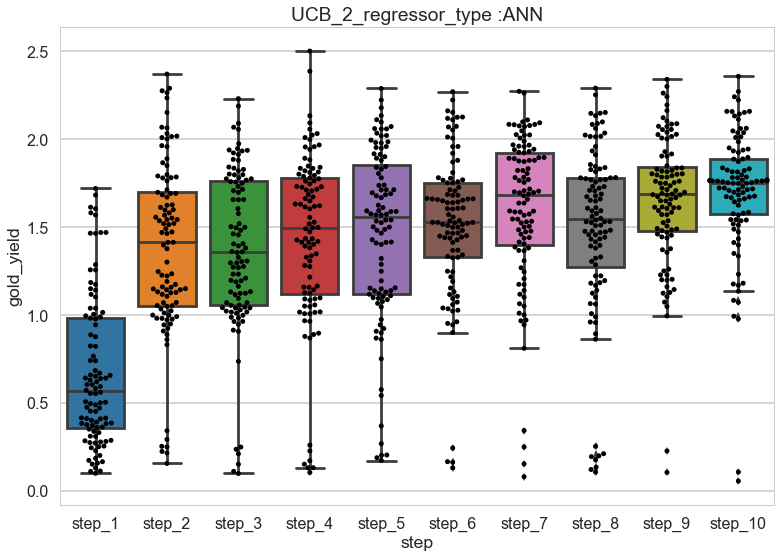

In [28]:
# Plotting
name = ['MLP', 'Linear', 'RandomForest', 'XGBRegressor', 'ANN']
for i in range(len(regressor_list)):
    boxplot(result_UCB_list_2[i], 'step', 'gold_yield', title='UCB_2_regressor_type :{}'.format(name[i]),point_size=5)

In [39]:
result_list = []
for regressor in regressor_list:
    # define our model that will be trained by active learning
    result, _ = active_learning(regressor, gold_regressor, allowed_conc, test_size=100, steps=10)
    result_list.append(result)

step:   1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:   1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:   1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:   1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10
step:   1
Epoch 1/1
100/100 [==============================] - 0s 1ms/step - loss: 0.5854 - mae: 0.5854
step:  2
Epoch 1/1
200/200 [==============================] - 0s 126us/step - loss: 0.3200 - mae: 0.3200
step:  3
Epoch 1/1
300/300 [==============================] - 0s 79us/step - loss: 0.2753 - mae: 0.2753
step:  4
Epoch 1/1
400/400 [==============================] - 0s 67us/step - loss: 0.2711 - mae: 0.2711
step:  5
Epoch 1/1
500/500 [==============================] - 0s 65us/step - loss: 0.2727 - mae: 0.2727
step:  6
Epoch 1/1
600/600 [==============================] - 0s 58us/step - loss: 0.2590 - mae: 0.2590
step:  

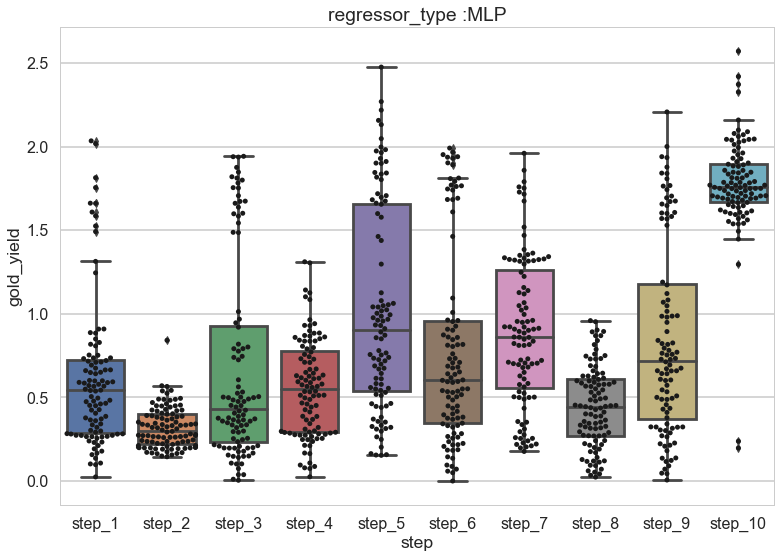

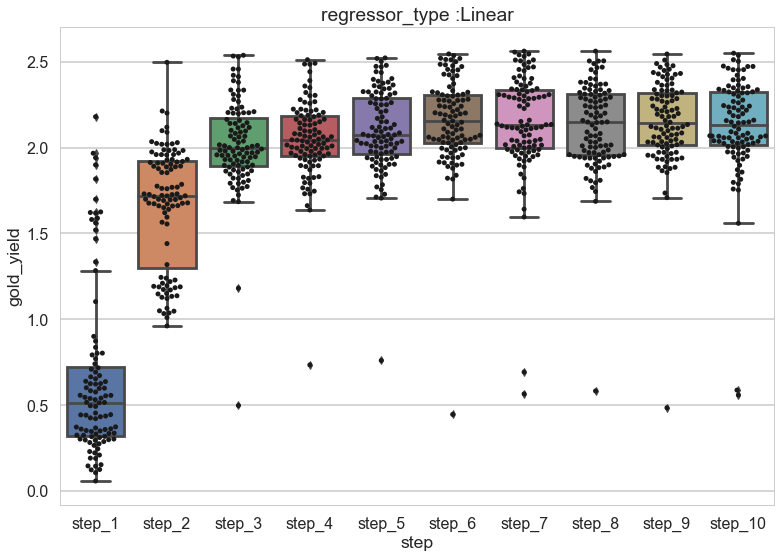

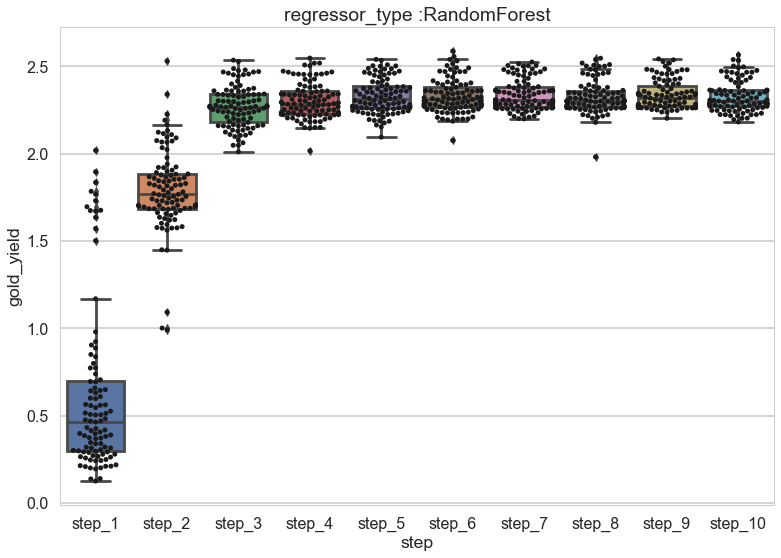

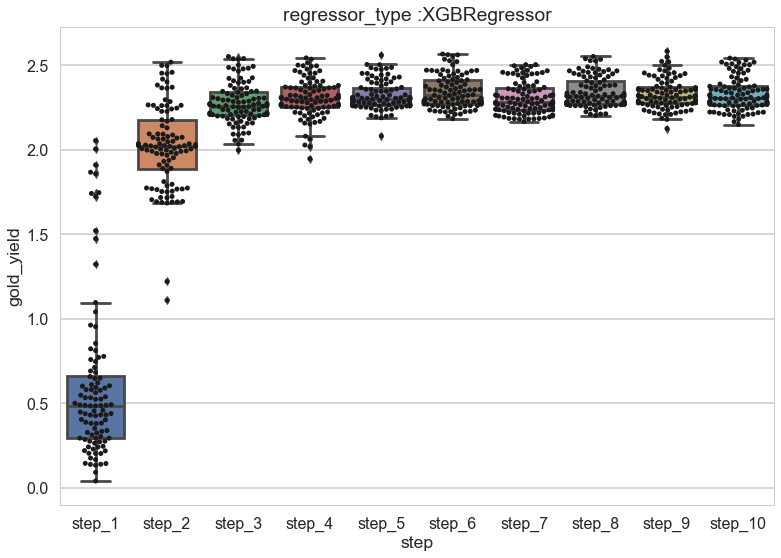

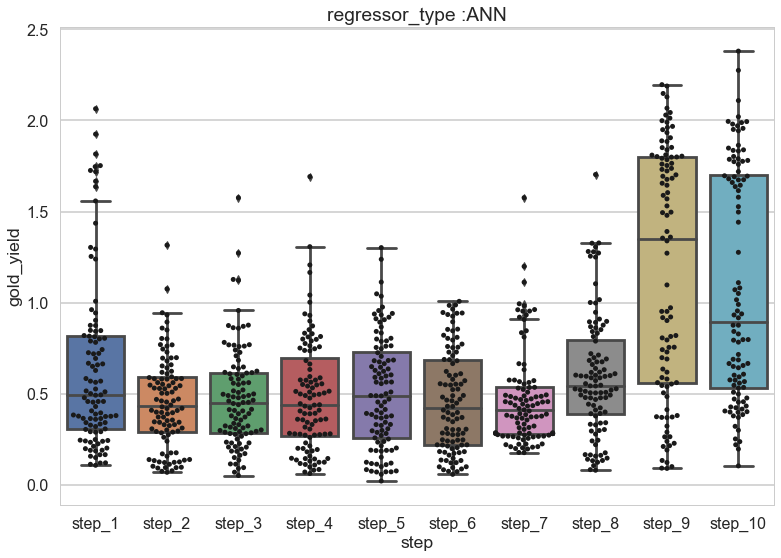

In [40]:
# Plotting
name = ['MLP', 'Linear', 'RandomForest', 'XGBRegressor', 'ANN']
for i in range(len(regressor_list)):
    boxplot(result_list[i], 'step', 'gold_yield', title='regressor_type :{}'.format(name[i]),point_size=5)

In [14]:
import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# define our RidgePlot Function
def ridgeplot(data, row, col):
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(data, row=row, hue=row, aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, col, clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, col, clip_on=False, color="w", lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, col)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    return g

c:\users\asus\desktop\ali\programming\pythoninstall\lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


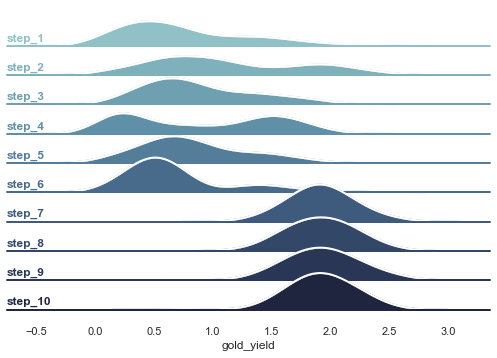

In [15]:
ridgeplot(result, 'step', 'gold_yield')